In [2]:
import sys
import os



import numpy as np
from SynthTempNetwork import Individual, SynthTempNetwork
from TemporalNetwork import ContTempNetwork, StaticTempNetwork
from FlowStability import SparseClustering, FlowIntegralClustering, run_multi_louvain, avg_norm_var_information
import parallel_clustering
import pickle

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.gridspec import GridSpec
import matplotx

from scipy.sparse import (lil_matrix, dok_matrix, diags, eye, isspmatrix_csr, isspmatrix,
                          csr_matrix, coo_matrix, csc_matrix)
from scipy.sparse.linalg import eigsh

from SparseStochMat import sparse_autocov_mat

Could not load sparse_dot_mkl. Will use scipy.sparse for matrix products.


In [3]:
net_heat = ContTempNetwork.load('fig3_growing_network300')
net_heat_disconnected = ContTempNetwork.load('fig3_growing_network300_disconnected')

# Check communities

In [4]:
net_heat.times

Index([0.010867646069036493,  0.02386229589341664,   0.0631979478676564,
        0.12523586182299767,  0.14119738696878154,  0.15083594401388595,
        0.15501089547519584,  0.16781030719605725,  0.18363426112506734,
        0.21481689967112408,
       ...
          299.7109202035304,   299.73916894405454,   299.77177197047126,
          299.7846607036029,    299.7907768954225,    299.8163601897989,
          299.8354351430701,   299.87599949291973,    299.8904545086285,
          299.8905950166158],
      dtype='float64', name='times', length=18596)

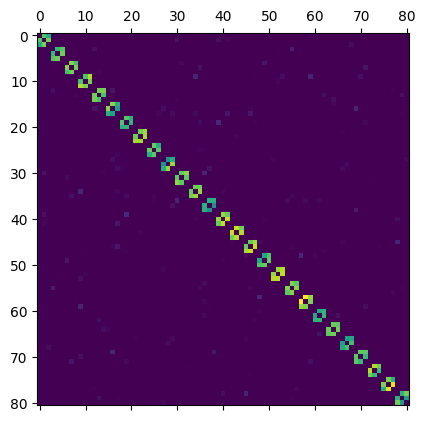

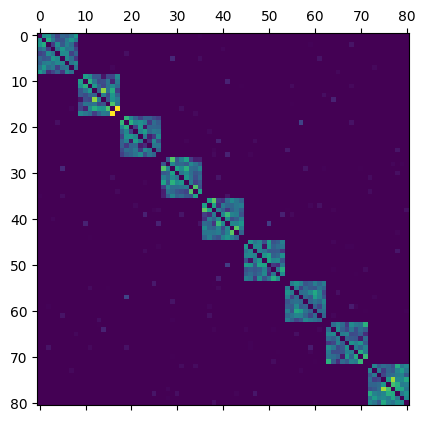

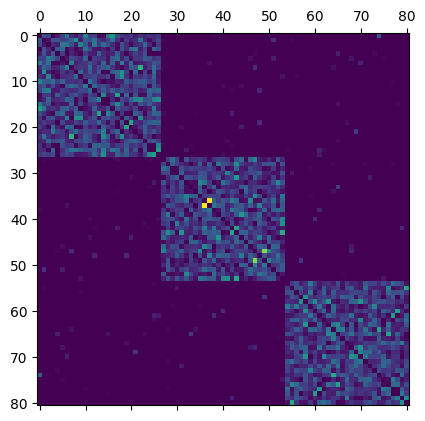

In [5]:
plt.matshow(net_heat.compute_static_adjacency_matrix(start_time=0, end_time=100).toarray())
#plt.savefig('/home/b/skoove/Desktop/growing300/aggregating1.png', format='png', dpi=300)
plt.matshow(net_heat.compute_static_adjacency_matrix(start_time=100, end_time=200).toarray())
#plt.savefig('/home/b/skoove/Desktop/growing300/aggregating2.png', format='png', dpi=300)
plt.matshow(net_heat.compute_static_adjacency_matrix(start_time=200, end_time=300).toarray())
#plt.savefig('/home/b/skoove/Desktop/growing300/aggregating3.png', format='png', dpi=300)

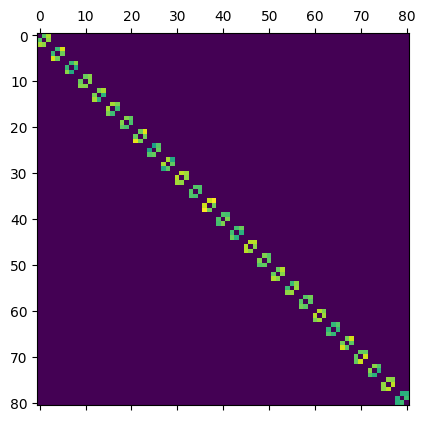

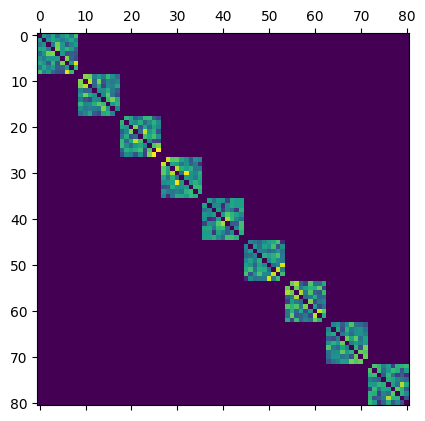

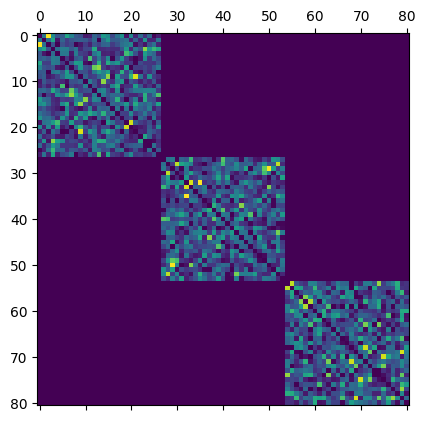

In [6]:
plt.matshow(net_heat_disconnected.compute_static_adjacency_matrix(start_time=0, end_time=100).toarray())
#plt.savefig('/home/b/skoove/Desktop/growing300/aggregating1.png', format='png', dpi=300)
plt.matshow(net_heat_disconnected.compute_static_adjacency_matrix(start_time=100, end_time=200).toarray())
#plt.savefig('/home/b/skoove/Desktop/growing300/aggregating2.png', format='png', dpi=300)
plt.matshow(net_heat_disconnected.compute_static_adjacency_matrix(start_time=200, end_time=300).toarray())
#plt.savefig('/home/b/skoove/Desktop/growing300/aggregating3.png', format='png', dpi=300)

In [7]:
lamdas_explore = np.logspace(-7,7,50)

In [8]:
multi_res_heat = {}
for lamda in lamdas_explore:
    with open(f'//scratch/tmp/180/skoove/growing_experiment300_temporal_rw/clustersexplore/cluster{lamda:.11f}', 'rb') as f:
        cluster = pickle.load(f)

    multi_res_heat[lamda] = cluster
avg_nclusters_forw_heat = [np.mean([len(c) for c in \
                   multi_res_heat[lamda] if len(c)>1]) for lamda in lamdas_explore]

NVI_forw_heat = [avg_norm_var_information(multi_res_heat[lamda]) for lamda in lamdas_explore]

In [9]:
print(avg_nclusters_forw_heat)

[81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 73.0, 27.0, 27.0, 27.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 8.99, 9.96, 10.08, 10.79, 9.71, 9.0, 9.53, 9.85, 8.84, 8.85, 9.69, 8.25, 8.07, 8.4, 8.42, 8.41, 8.45, 8.4, 8.44, 8.35, 8.44, 8.46, 8.47, 8.4, 8.53, 8.4, 8.36, 8.42]


In [10]:
print(NVI_forw_heat)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0009919880674604136, 0.035190731654552505, 0.06267793713374568, 0.05063917123907661, 0.04823516254324863, 0.005320656257789179, 0.029041600341389986, 0.01991383631606942, 0.017544674314246268, 0.023158848975975928, 0.044394846127934096, 0.04835128380316084, 0.030840043944948093, 0.03809172508905387, 0.03881990945664825, 0.03534716022475768, 0.0407743273788114, 0.042980965717696766, 0.03832315194689689, 0.034305915076079635, 0.037911900110187934, 0.03928410123272285, 0.04189305376227435, 0.037967672251567074, 0.044798790805803596, 0.03628340990199256, 0.036726983848521466, 0.03981916386269656]


we will study lamdas within the range (10e-4, 10e-0)

# Derivative

In [11]:
lamdas_growing = np.logspace(-4.5,-0.5,200)

In [12]:
multi_res_heat = {}
for lamda in lamdas_growing:
    with open(f'//scratch/tmp/180/skoove/growing_experiment300_temporal_heat/clustersplot/cluster{lamda:.11f}', 'rb') as f:
        cluster = pickle.load(f)

    multi_res_heat[lamda] = cluster
avg_nclusters_forw_heat = [np.mean([len(c) for c in \
                   multi_res_heat[lamda] if len(c)>1]) for lamda in lamdas_growing]

NVI_forw_heat = [avg_norm_var_information(multi_res_heat[lamda]) for lamda in lamdas_growing]

multi_res_rw = {}
for lamda in lamdas_growing:
    with open(f'//scratch/tmp/180/skoove/growing_experiment300_temporal_rw/clustersplot/cluster{lamda:.11f}', 'rb') as f:
        cluster = pickle.load(f)
        
    multi_res_rw[lamda] = cluster
avg_nclusters_forw_rw = [np.mean([len(c) for c in \
                   multi_res_rw[lamda] if len(c)>1]) for lamda in lamdas_growing]

NVI_forw_rw = [avg_norm_var_information(multi_res_rw[lamda]) for lamda in lamdas_growing]

In [13]:
def derivative(v1, v2):
    assert len(v1) == len(v2), "Error: in order to compute the numerical derivative, the two varibales need to have the same lenght."
    derivative = []
    for i, vi in enumerate(v1[1:]):
        m1 =(vi - v1[i-1])/(v2[i]-v2[i-1])
        m2 =(v1[i+1] - vi)/(v2[i+1]-v2[i])
        derivative.append((m1+m2)/2)
    return derivative

In [14]:
lamdas_vNS = np.logspace(-3,1,200)

vNS_heat_end = []
vNS_rw_end = []
for i, lamda in enumerate(lamdas_vNS):
    with open(f'//scratch/tmp/180/skoove/growing_experiment300_temporal_heat/vNS/vNS{lamda:.11f}', 'rb') as f:
        S = pickle.load(f)['vNS']
        vNS_heat_end.append(S[list(S.keys())[0]][0])

    with open(f'//scratch/tmp/180/skoove/growing_experiment300_temporal_rw/vNS/vNS{lamda:.11f}', 'rb') as f:
        S = pickle.load(f)['vNS']
        vNS_rw_end.append(S[list(S.keys())[0]][0])

In [15]:
S1 = vNS_rw_end
S2 = vNS_heat_end


between_lamdas_vNS = np.linspace(-3,1,200)

Q1 = derivative(S1, between_lamdas_vNS)
Q2 = derivative(S2, between_lamdas_vNS)


/home/b/skoove/Desktop/entropy/entropy_env/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/b/skoove/Desktop/entropy/entropy_env/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


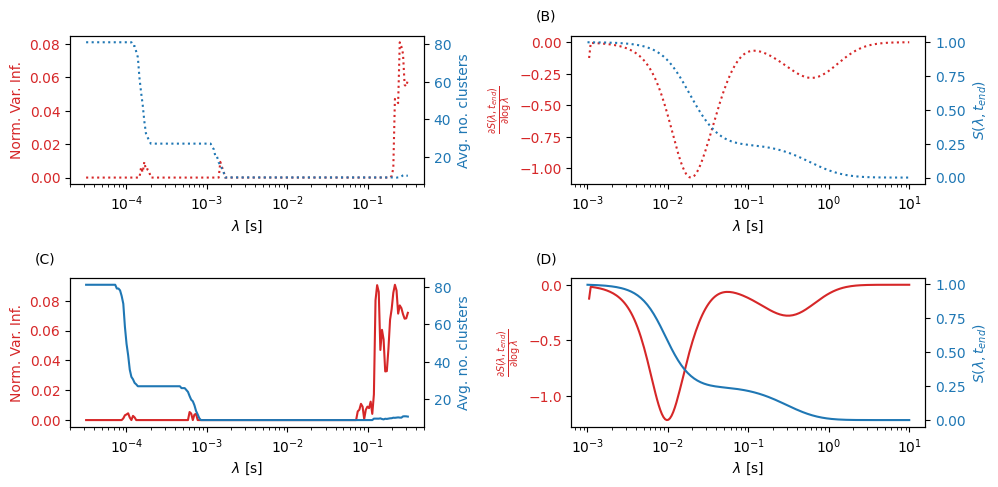

In [16]:
fig, axs = plt.subplots(2,2, sharex=False, figsize=(10, 5))

####### First Plot
color = 'tab:red'
axs[0,0].plot(lamdas_growing, NVI_forw_rw, ':', color=color, label='static norm NVI')

axs[0,0].set_xscale('log')
axs[0,0].set_xlabel(r'$\lambda$ [s]')
axs[0,0].set_ylabel('Norm. Var. Inf.', color=color)
axs[0,0].tick_params(axis='y', labelcolor=color)
#axs[0,0].text(-0.1,1.1, '(A)', transform=axs[0,0].transAxes)

ax1 = axs[0,0].twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax1.plot(lamdas_growing, avg_nclusters_forw_rw, ':', color=color, label='edge-centric')

ax1.set_xlabel(r'$\lambda$ [s]')
ax1.set_ylabel('Avg. no. clusters', color=color)  # we already handled the x-label with ax1
ax1.tick_params(axis='y', labelcolor=color)

####### Second Plot

color = 'tab:red'
axs[0,1].plot(lamdas_vNS[1:], Q1, ':', color=color, label='dvNSdt')

axs[0,1].set_xscale('log')
axs[0,1].set_xlabel(r'$\lambda$ [s]')

axs[0,1].set_ylabel(r'$\frac{\partial S(\lambda, t_{end})}{\partial \log\lambda}$', color=color)
axs[0,1].tick_params(axis='y', labelcolor=color)
axs[0,1].text(-0.1,1.1, '(B)', transform=axs[0,1].transAxes)

ax2 = axs[0,1].twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.plot(lamdas_vNS, vNS_rw_end, ':', color=color, label='vNS')

ax2.set_ylabel(r'$S(\lambda, t_{end})$', color=color)  # we already handled the x-label with ax1
ax2.tick_params(axis='y', labelcolor=color)



####### Third Plot
color = 'tab:red'
axs[1,0].plot(lamdas_growing, NVI_forw_heat, color=color, label='static norm NVI')

axs[1,0].set_xscale('log')
axs[1,0].set_xlabel(r'$\lambda$ [s]')
axs[1,0].set_ylabel('Norm. Var. Inf.', color=color)
axs[1,0].tick_params(axis='y', labelcolor=color)
axs[1,0].text(-0.1,1.1, '(C)', transform=axs[1,0].transAxes)

ax3 = axs[1,0].twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax3.plot(lamdas_growing, avg_nclusters_forw_heat, color=color, label='edge-centric')

ax3.set_xlabel(r'$\lambda$ [s]')
ax3.set_ylabel('Avg. no. clusters', color=color)  # we already handled the x-label with ax1
ax3.tick_params(axis='y', labelcolor=color)

####### Fourth Plot

color = 'tab:red'
axs[1,1].plot(lamdas_vNS[1:], Q2, color=color, label='dvNSdt')

axs[1,1].set_xscale('log')
axs[1,1].set_xlabel(r'$\lambda$ [s]')

axs[1,1].set_ylabel(r'$\frac{\partial S(\lambda, t_{end})}{\partial \log\lambda}$', color=color)
axs[1,1].tick_params(axis='y', labelcolor=color)
axs[1,1].text(-0.1,1.1, '(D)', transform=axs[1,1].transAxes)

ax4 = axs[1,1].twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax4.plot(lamdas_vNS, vNS_heat_end, color=color, label='vNS')

ax4.set_ylabel(r'$S(\lambda, t_{end})$', color=color)  # we already handled the x-label with ax1
ax4.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
#plt.savefig('/home/b/skoove/Desktop/growing300/clustering_vNS_growing300.png', format='png', dpi=300)

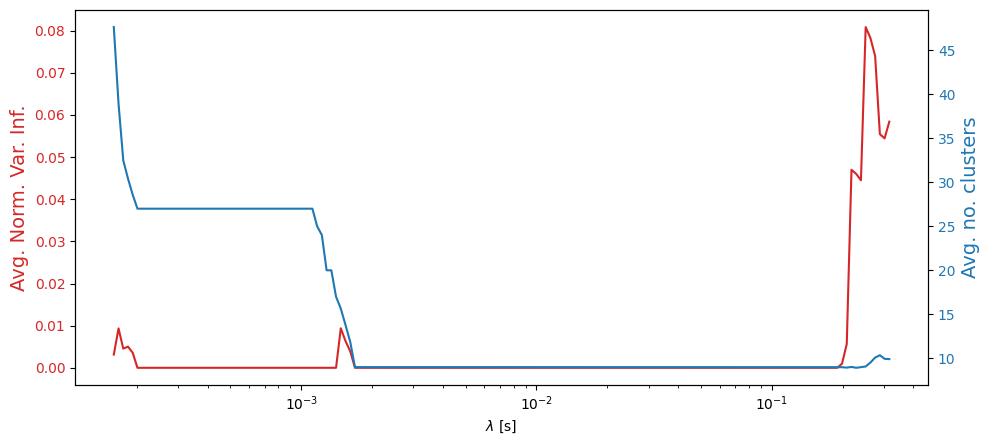

In [17]:
fig, axs = plt.subplots(1,1, sharex=False, figsize=(10, 5))

####### First Plot
color = 'tab:red'
axs.plot(lamdas_growing[35:], NVI_forw_rw[35:], color=color, label='static norm NVI')

axs.set_xscale('log')
axs.set_xlabel(r'$\lambda$ [s]')
axs.set_ylabel('Avg. Norm. Var. Inf.', color=color, fontsize = 14)
axs.tick_params(axis='y', labelcolor=color)
# axs.text(-0.1,1.1, '(A)', transform=axs.transAxes)

ax1 = axs.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax1.plot(lamdas_growing[35:], avg_nclusters_forw_rw[35:], color=color, label='edge-centric')

ax1.set_xlabel(r'$\lambda$ [s]', fontsize = 14)
ax1.set_ylabel('Avg. no. clusters', color=color, fontsize = 14)  # we already handled the x-label with ax1
ax1.tick_params(axis='y', labelcolor=color)


# fig.suptitle("A,B --> rw, C,D --> heat", fontsize=12)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.subplots_adjust(top=0.88) # # Tight layout requires the title to be spaced accordingly

#plt.savefig('/home/b/skoove/Desktop/growing300/forward_clustering.png', format='png', dpi=600)

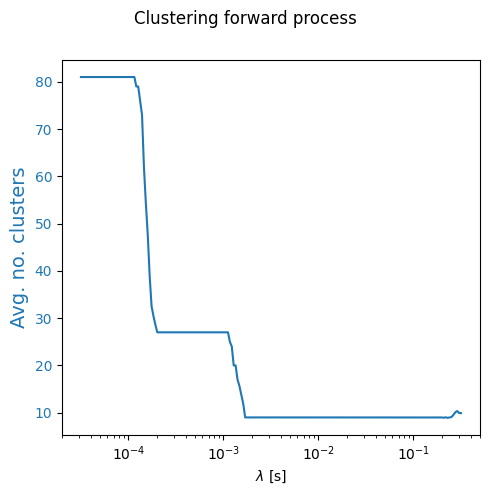

In [20]:
fig, axs = plt.subplots(1,1, sharex=False, figsize=(5, 5))

####### First Plot
color = 'tab:blue'
axs.plot(lamdas_growing, avg_nclusters_forw_rw, color=color)

axs.set_xscale('log')
axs.set_xlabel(r'$\lambda$ [s]')
axs.set_ylabel('Avg. no. clusters', color=color, fontsize = 14)
axs.tick_params(axis='y', labelcolor=color)

# fig.suptitle("A,B --> rw, C,D --> heat", fontsize=12)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.subplots_adjust(top=0.88) # # Tight layout requires the title to be spaced accordingly

fig.suptitle('Clustering forward process')
#plt.savefig('/home/b/skoove/Desktop/growing300/forward_clusters.png', format='png', dpi=600)

In [38]:
folder = '//scratch/tmp/180/skoove/growing_experiment300_temporal_heat'
with open(folder + f'/TvNS/T{lamda:.11f}', 'rb') as f:
        dict_T_heat = pickle.load(f)

In [39]:
folder = '//scratch/tmp/180/skoove/growing_experiment300_temporal_rw'
with open(folder + f'/TvNS/T{lamda:.11f}', 'rb') as f:
        dict_T_rw = pickle.load(f)

In [40]:
T_heat = dict_T_heat['T'][1000].toarray()
T_rw = dict_T_rw['T'][1000].toarray()

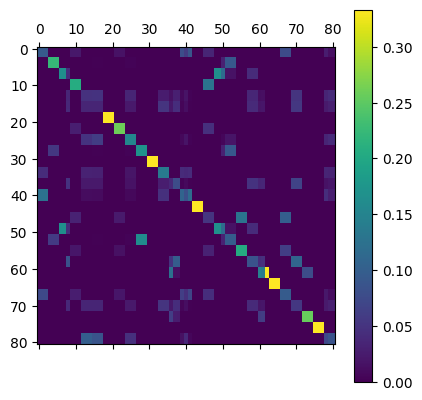

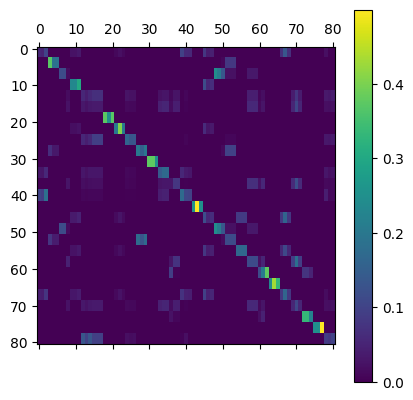

In [41]:
plt.matshow(T_heat)
plt.colorbar()
plt.matshow(T_rw)
plt.colorbar()

In [42]:
np.linalg.eigvals(T_heat)

array([ 1.00000000e+00+0.00000000e+00j,  9.65521101e-01+0.00000000e+00j,
        9.36528114e-01+0.00000000e+00j,  8.49306812e-01+0.00000000e+00j,
        8.14004388e-01+0.00000000e+00j,  7.08797534e-01+0.00000000e+00j,
        5.76934891e-01+1.57606100e-02j,  5.76934891e-01-1.57606100e-02j,
        3.92863828e-01+2.34598217e-02j,  3.92863828e-01-2.34598217e-02j,
        1.69257094e-01+0.00000000e+00j,  2.21273731e-01+0.00000000e+00j,
        5.17494872e-01+0.00000000e+00j,  5.11515222e-01+0.00000000e+00j,
        3.55445896e-02+0.00000000e+00j,  1.06440915e-02+0.00000000e+00j,
        1.39090080e-02+0.00000000e+00j,  4.93095484e-03+0.00000000e+00j,
        1.00000000e+00+0.00000000e+00j,  3.50056629e-04+0.00000000e+00j,
        2.75493217e-04+0.00000000e+00j,  2.12888916e-06+0.00000000e+00j,
        1.72828200e-13+0.00000000e+00j, -6.05145151e-18+1.34614716e-16j,
       -6.05145151e-18-1.34614716e-16j, -1.17054631e-16+0.00000000e+00j,
        8.86537302e-17+0.00000000e+00j,  2.38429549

# Last Plot

In [43]:
selected_lamdas = np.logspace(-3,1,10)
sample_times = list(np.arange(0, len(net_heat.times), 10))
sample_times_disconnected = list(np.arange(0, len(net_heat_disconnected.times), 10))

In [44]:
vNS_selected = []
for i, lamda in enumerate(selected_lamdas):
    with open(f'//scratch/tmp/180/skoove/growing_experiment300_temporal_rw/vNS_selected/vNS{lamda:.11f}', 'rb') as f:
        S = pickle.load(f)
        vNS_selected.append(S['vNS'][f'{lamda:.11f}']) #(S[list(S.keys())[0]][0])

# vNS_selected_disconnected = []
# for i, lamda in enumerate(selected_lamdas):
#     with open(f'//scratch/tmp/180/skoove/growing_experiment300_disconnected_temporal_heat/vNS_selected/vNS{lamda:.11f}', 'rb') as f:
#         S = pickle.load(f)
#         vNS_selected_disconnected.append(S['vNS'][f'{lamda:.11f}']) #(S[list(S.keys())[0]][0])

/home/b/skoove/Desktop/entropy/entropy_env/lib/python3.10/site-packages/matplotx/_optimize.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
  s[mask] = numpy.linalg.lstsq(AtA[mask][:, mask], Atb[mask], rcond=None)[0]
/tmp/ipykernel_358787/1270021801.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()  # otherwise the right y-label is slightly clipped
/home/b/skoove/Desktop/entropy/entropy_env/lib/python3.10/site-packages/matplotlib/text.py:754: ComplexWarning: Casting complex values to real discards the imaginary part
  posy = float(self.convert_yunits(self._y))
/home/b/skoove/Desktop/entropy/entropy_env/lib/python3.10/site-packages/matplotlib/text.py:895: ComplexWarning: Casting complex values to real discards the imaginary part
  y = float(self.convert_yunits(self._y))


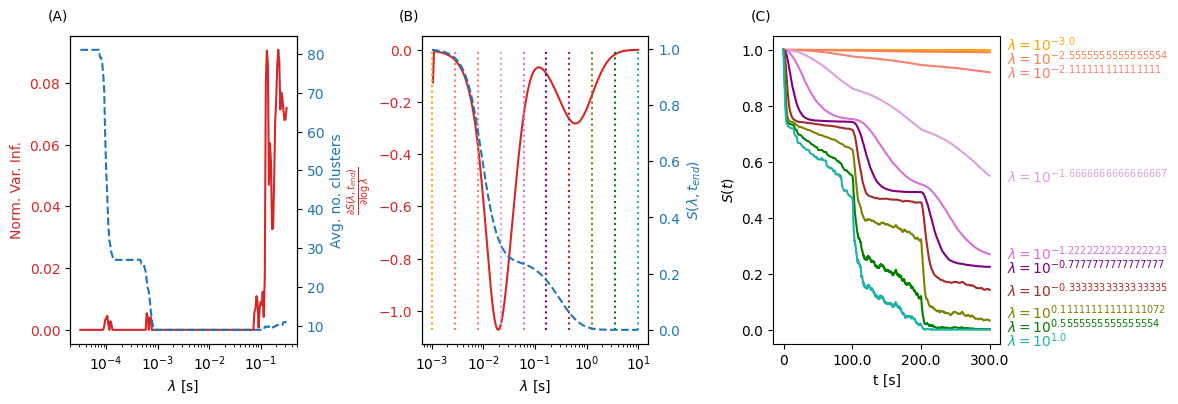

In [46]:
# Create a 2x3 grid of subplots with specific figure size
fig = plt.figure(figsize=(12, 4))
gs = GridSpec(1, 3, width_ratios=[1, 1, 1], hspace=0.3, wspace=0.55)


####### Third Plot
color = 'tab:red'
axsc = plt.subplot(gs[0,0])
axsc.plot(lamdas_growing, NVI_forw_heat, color=color)

axsc.set_xscale('log')
axsc.set_xlabel(r'$\lambda$ [s]')
axsc.set_ylabel('Norm. Var. Inf.', color=color)
axsc.tick_params(axis='y', labelcolor=color)
axsc.text(-0.1,1.05, '(A)', transform=axsc.transAxes)

ax3 = axsc.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax3.plot(lamdas_growing, avg_nclusters_forw_heat, '--', color=color)

ax3.set_xlabel(r'$\lambda$ [s]')
ax3.set_ylabel('Avg. no. clusters', color=color)  # we already handled the x-label with ax1
ax3.tick_params(axis='y', labelcolor=color)

####### Fourth Plot

color = 'tab:red'
axsd = plt.subplot(gs[0,1])
axsd.plot(lamdas_vNS[1:], Q1, color=color, label='dvNSdt')

axsd.set_xscale('log')
axsd.set_xlabel(r'$\lambda$ [s]')

axsd.set_ylabel(r'$\frac{\partial S(\lambda, t_{end})}{\partial \log\lambda}$', color=color)
axsd.tick_params(axis='y', labelcolor=color)
axsd.text(-0.1,1.05, '(B)', transform=axsd.transAxes)

min_ds7dt = np.min(Q1)
max_ds7dt = np.max(Q1)
list_colors = ['orange', 'coral', 'salmon', 'plum', 'orchid', 'purple', 'brown', 'olive', 'green', 'lightseagreen']
axsd.vlines(x = selected_lamdas,
            ymin = [min_ds7dt, min_ds7dt, min_ds7dt, min_ds7dt, min_ds7dt, min_ds7dt, min_ds7dt, min_ds7dt, min_ds7dt, min_ds7dt],
            ymax = [max_ds7dt, max_ds7dt, max_ds7dt, max_ds7dt, max_ds7dt, max_ds7dt, max_ds7dt, max_ds7dt, max_ds7dt, max_ds7dt],
            colors= list_colors, linestyles='dotted')

ax4 = axsd.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax4.plot(lamdas_vNS, vNS_heat_end, '--', color=color, label='vNS')

ax4.set_ylabel(r'$S(\lambda, t_{end})$', color=color)  # we already handled the x-label with ax1
ax4.tick_params(axis='y', labelcolor=color)


#Plot 5
list_annotate_y = []
for i, lamda in enumerate(selected_lamdas):
    list_annotate_y.append(np.mean(vNS_selected[i]))

shift_annotate_y = [0.01, 0.03, 0.02, -0.05, -0.4, -0.35, -0.05, -0.05, -0.06]

axse = plt.subplot(gs[0,2])
for i, lamda in enumerate(selected_lamdas):
    #axse.plot(net_heat.times[sample_times], vNS_heat0_50[i], label=r'log$(\lambda) = $' + f'{np.linspace(-2.5,0,9)[i]}')
    exponent = f'{np.linspace(-3,1,10)[i]}' #"{:.2e}".format(selected_lamdas[i]) #f'{np.linspace(-2.5,0,9)[i]}'
    axse.plot(net_heat.times[sample_times], vNS_selected[i], color = list_colors[i], label=r'$\lambda = 10^{%s} $' % exponent)
    axse.set_xlabel('t [s]')
    #axse.annotate(text = r'$\lambda = e^{%s}$' % exponent, xy=[100, list_annotate_y[i]], xytext=[105, list_annotate_y[i]+shift_annotate_y[1]-0.05], color='magenta')
axse.text(-0.1,1.05, '(C)', transform=axse.transAxes)
axse.set_ylabel(r'$S(t)$')
matplotx.line_labels()
#axse.legend(fontsize='small', loc='upper left', bbox_to_anchor=(1.05, 1))


deltat1 = 300 / 3
plt.xticks([0, deltat1, 2*deltat1, 3*deltat1,],[0, str(deltat1), str(2*deltat1), str(3*deltat1)])


fig.tight_layout()  # otherwise the right y-label is slightly clipped
#plt.savefig('/home/b/skoove/Desktop/plots250/figNetSci_rev.eps', format='eps', dpi=300)
plt.show()

# Entropy Rate

In [47]:
Conditional_S_selected = []
for i, lamda in enumerate(selected_lamdas):
    with open(f'//scratch/tmp/180/skoove/growing_experiment300_temporal_rw/conditional_S_selected/S_rate{lamda:.11f}', 'rb') as f:
        S_rate = pickle.load(f)
        Conditional_S_selected.append(S_rate['S_rate'][f'{lamda:.11f}']) #(S[list(S.keys))[0]][0])

In [54]:
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)

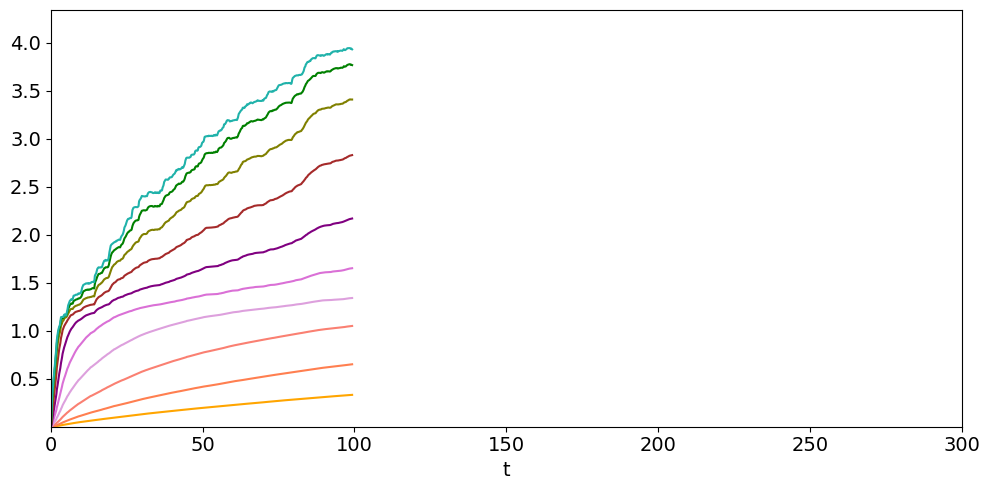

In [63]:
fig, axs = plt.subplots(1,1, sharex=False, figsize=(10, 5))

list_colors = ['orange', 'coral', 'salmon', 'plum', 'orchid', 'purple', 'brown', 'olive', 'green', 'lightseagreen']

####### Fourth Plot

for i, lamda in enumerate(selected_lamdas):
    axs.plot(net_heat.times[sample_times][0:400], Conditional_S_selected[i][0:400], color = list_colors[i], label='lamda = ' + f'{lamda:.11f}')


axs.set_xlabel('t', fontsize = 14)
axs.set_xlim([0, 300])
#axs.set_ylabel('Sh')
ymin = np.min(Conditional_S_selected[0])
ymax = np.max(Conditional_S_selected[-1])
axs.set_ylim([ymin, ymax])
#axs.set_ylabel(r'$\frac{\partial S(\lambda, t_{end})}{\partial \log\lambda}$', color=color)
axs.tick_params(axis='y')



#plt.legend(fontsize='xx-small', loc='upper left',  bbox_to_anchor=(1.05, 1))

#fig.suptitle("Conditional Entropy H(pt | p0)", fontsize=12)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
#fig.subplots_adjust(top=0.88) # # Tight layout requires the title to be spaced accordingly
plt.savefig('/home/b/skoove/Desktop/growing300/growing300_conditionalH0_100.png', format='png', dpi=600)

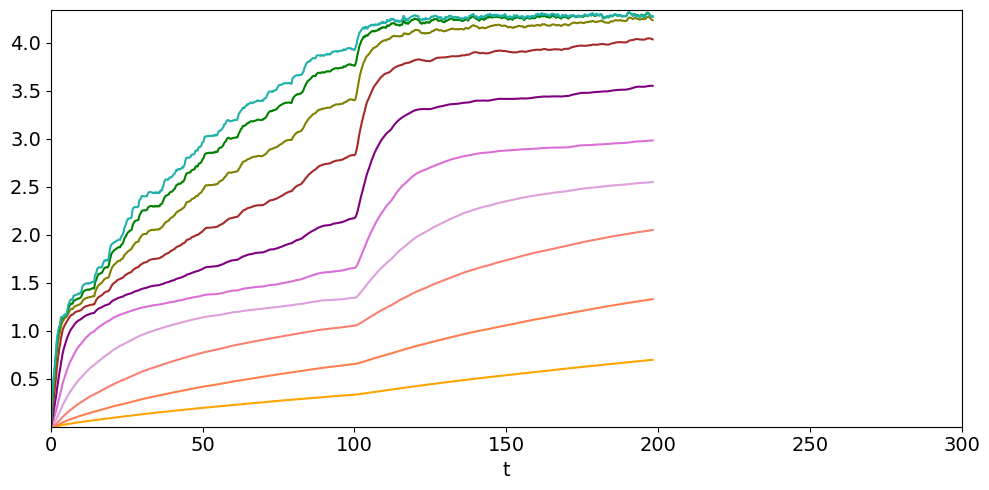

In [61]:
fig, axs = plt.subplots(1,1, sharex=False, figsize=(10, 5))

list_colors = ['orange', 'coral', 'salmon', 'plum', 'orchid', 'purple', 'brown', 'olive', 'green', 'lightseagreen']

####### Fourth Plot

for i, lamda in enumerate(selected_lamdas):
    axs.plot(net_heat.times[sample_times][0:1075], Conditional_S_selected[i][0:1075], color = list_colors[i], label='lamda = ' + f'{lamda:.11f}')


axs.set_xlabel('t', fontsize = 14)
axs.set_xlim([0, 300])
#axs.set_ylabel('Sh')
ymin = np.min(Conditional_S_selected[0])
ymax = np.max(Conditional_S_selected[-1])
axs.set_ylim([ymin, ymax])
#axs.set_ylabel(r'$\frac{\partial S(\lambda, t_{end})}{\partial \log\lambda}$', color=color)
axs.tick_params(axis='y')



#plt.legend(fontsize='xx-small', loc='upper left',  bbox_to_anchor=(1.05, 1))

#fig.suptitle("Conditional Entropy H(pt | p0)", fontsize=12)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
#fig.subplots_adjust(top=0.88) # # Tight layout requires the title to be spaced accordingly
plt.savefig('/home/b/skoove/Desktop/growing300/growing300_conditionalH0_200.png', format='png', dpi=600)

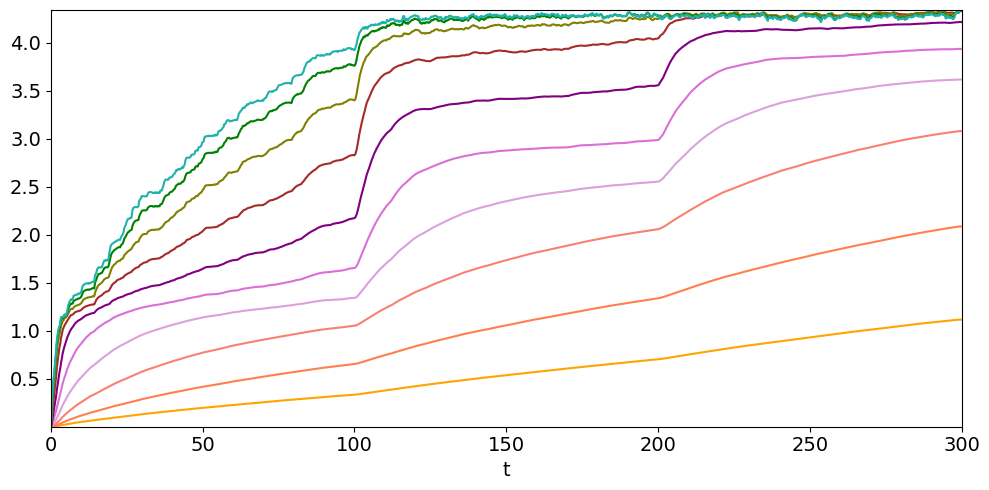

In [62]:
fig, axs = plt.subplots(1,1, sharex=False, figsize=(10, 5))

list_colors = ['orange', 'coral', 'salmon', 'plum', 'orchid', 'purple', 'brown', 'olive', 'green', 'lightseagreen']

####### Fourth Plot

for i, lamda in enumerate(selected_lamdas):
    axs.plot(net_heat.times[sample_times], Conditional_S_selected[i], color = list_colors[i], label='lamda = ' + f'{lamda:.11f}')


axs.set_xlabel('t', fontsize = 14)
axs.set_xlim([0, 300])
#axs.set_ylabel('Sh')
ymin = np.min(Conditional_S_selected[0])
ymax = np.max(Conditional_S_selected[-1])
axs.set_ylim([ymin, ymax])
#axs.set_ylabel(r'$\frac{\partial S(\lambda, t_{end})}{\partial \log\lambda}$', color=color)
axs.tick_params(axis='y')



#plt.legend(fontsize='xx-small', loc='upper left',  bbox_to_anchor=(1.05, 1))

#fig.suptitle("Conditional Entropy H(pt | p0)", fontsize=12)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
#fig.subplots_adjust(top=0.88) # # Tight layout requires the title to be spaced accordingly
plt.savefig('/home/b/skoove/Desktop/growing300/growing300_conditionalH0_300.png', format='png', dpi=600)

plt.show()

In [64]:
S_rate_selected = []
for i, lamda in enumerate(selected_lamdas):
    with open(f'//scratch/tmp/180/skoove/growing_experiment300_temporal_rw/S_rate_selected/S_rate{lamda:.11f}', 'rb') as f:
        S_rate = pickle.load(f)
        S_rate_selected.append(S_rate['S_rate'][f'{lamda:.11f}']) #(S[list(S.keys())[0]][0])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


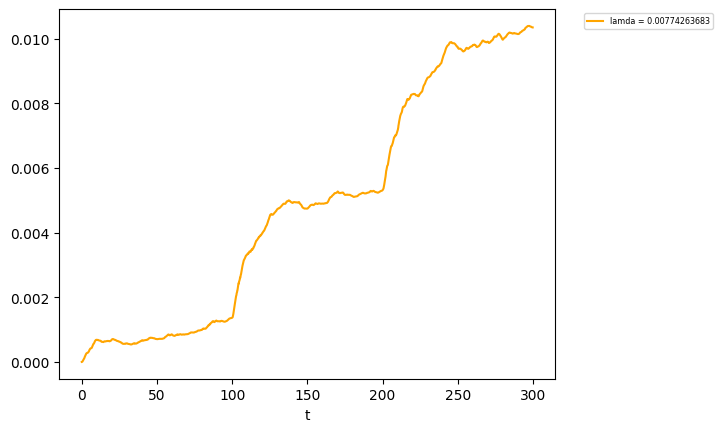

In [72]:
#Plot 5
list_colors = ['orange', 'coral', 'salmon', 'plum', 'orchid', 'purple', 'brown', 'olive', 'green', 'lightseagreen']


for i, lamda in enumerate(selected_lamdas[2:4:2]):
    plt.plot(net_heat.times[sample_times], S_rate_selected[2*i], color = list_colors[2*i], label='lamda = ' + f'{lamda:.11f}')
    plt.xlabel('t')


plt.legend(fontsize='xx-small', loc='upper left',  bbox_to_anchor=(1.05, 1))

plt.savefig('/home/b/skoove/Desktop/S_rate_rw.eps', format='eps')
plt.show()

In [78]:
instantaneous_S_rate_selected = []
for i, lamda in enumerate(selected_lamdas):
    with open(f'//scratch/tmp/180/skoove/growing_experiment300_temporal_rw/instantaneous_S_rate_selected/S_rate{lamda:.11f}', 'rb') as f:
        S_rate = pickle.load(f)
        instantaneous_S_rate_selected.append(S_rate['S_rate'][f'{lamda:.11f}'])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


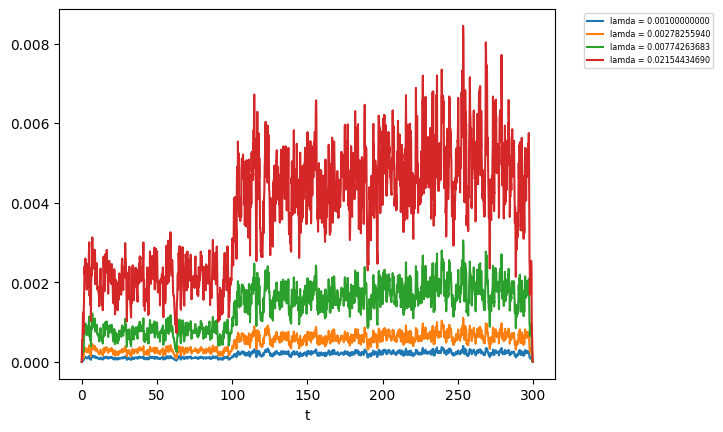

In [79]:
#Plot 5

for i, lamda in enumerate(selected_lamdas[0:4]):
    plt.plot(net_heat.times[sample_times], instantaneous_S_rate_selected[i], label='lamda = ' + f'{lamda:.11f}')
    plt.xlabel('t')


plt.legend(fontsize='xx-small', loc='upper left',  bbox_to_anchor=(1.05, 1))
plt.savefig('/home/b/skoove/Desktop/inst_S_rate_rw.eps', format='eps')
plt.show()

In [ ]:
folder = '//scratch/tmp/180/skoove/growing_experiment300_temporal_heat'
lamda = selected_lamdas[5]
with open(folder + '/L', 'rb') as f:
    dict_L = pickle.load(f)

with open(folder + f'/TvNS_selected/T{lamda:.11f}', 'rb') as f:
        dict_T = pickle.load(f)

p0 = 1/net_heat.num_nodes*np.ones(net_heat.num_nodes)
L = dict_L['L'][15000].tocsr()
T = dict_T['T'][15000].tocsr()
p = p0 @ T

In [ ]:
s = 0
for i in range(net_heat.num_nodes):
    for j in range(net_heat.num_nodes):
        if L[i,j] > 0 and L[j,i] > 0 : #sufficient to check only one of the two between inter_T[i,j] and inter_T[j,i]?
            s += (p[i] * (-lamda * L[i,j]) - p[j] * (-lamda * L[j,i])) * np.log((p[i] * (- lamda * L[i,j])) / (p[j] * (- lamda * L[j,i])))

In [ ]:
L.toarray()[6]

In [ ]:
i= 0
j= 6
print(L[i,j])
print(L[j,i])
print(p[i])
print(p[j])
print(p[i] * (-lamda * L[i,j]))
print(p[i] * (-lamda * L[i,j]) - p[j] * (-lamda * L[j,i]))
print(np.log((p[i] * (- lamda * L[i,j])) / (p[j] * (- lamda * L[j,i]))))

In [ ]:
i= 6
j= 0
print(L[i,j])
print(L[j,i])
print(p[i])
print(p[j])
print(p[i] * (-lamda * L[i,j]))
print(p[i] * (-lamda * L[i,j]) - p[j] * (-lamda * L[j,i]))
print(np.log((p[i] * (- lamda * L[i,j])) / (p[j] * (- lamda * L[j,i]))))

In [ ]:
p_1 = [p0[0]] + [(p0 @ dict_T['T'][i])[0] for i in range(len(net_heat.times)-1)]

In [ ]:
plt.plot(net_heat.times, p_1)

In [ ]:
plt.matshow(dict_T['T'][-1].toarray())
plt.colorbar()